# Random Forest for Airbnb


**Outline**

* [Read Data](#read)
* [Data Transformation](#transform)
* [Model Building](#model) 
    * [Parameter Tuning](#tune)
* [Feature Importance](#feature) 
* [Reference](#refer)

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
# import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier

SEED = 12345

## <a id="read">Read Data</a>

In [61]:
def data_reader():
    """
    read data into notebook 
    """
        
    data_dir = os.path.join('.') #, 'data'

    train_binary_path = os.path.join(data_dir, 'train_session_updated.csv')  
    train_binary = pd.read_csv(train_binary_path) #, index_col = 0
    if 'Unnamed: 0' in train_binary.columns:
        del train_binary['Unnamed: 0']
    drop_feature = ['user_id', 'total_secs_elapsed', 'date_account_created','timestamp_first_active','date_first_booking','country_destination']
    train_binary.drop(drop_feature, axis=1, inplace=True)

    return train_binary

In [62]:
train_binary = data_reader()

In [63]:
train_binary.columns

Index(['ajax_refresh_subtotal', 'dashboard', 'edit', 'header_userpic',
       'personalize', 'similar_listings', 'total_actions', 'obs_count',
       'unique_action', 'unique_device', 'avg_time', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'isNDF'],
      dtype='object')

## <a id="transform">Data Transformation</a>

In [5]:
categorical = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel',
                'affiliate_provider','first_affiliate_tracked','signup_app','first_device_type',
               'first_browser']    

In [6]:
# Convert data type as 'category'
for i in categorical:
    train_binary[i] = train_binary[i].astype('category')

In [7]:
# Create dummy variables
train_binary_dummy = pd.get_dummies(train_binary, columns = categorical)
train_binary_dummy.head()

,ajax_refresh_subtotal,dashboard,edit,header_userpic,personalize,similar_listings,total_actions,obs_count,unique_action,unique_device,...,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_Sogou Explorer,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,2,4,0,2,4,3,15,3.713572,13,2,...,0,1,0,0,0,0,0,0,0,0
1,0,2,0,2,0,0,4,6.672033,25,2,...,0,0,0,0,0,0,0,0,0,0
2,21,3,0,2,26,12,64,6.194405,20,1,...,0,1,0,0,0,0,0,0,0,0
3,12,2,18,2,12,17,63,5.181784,38,2,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,1,4,1,11,3.295837,11,2,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Split data into response and predictors
y = train_binary_dummy['isNDF']
x = train_binary_dummy.drop('isNDF', axis=1)

## <a id="model">Model Building</a>

In [9]:
def fit_randomforest(X_train, y_train, param_setting={}, fold=5, seed=SEED):
    """Random Forest for Classification, get the CV AUC"""

    # set seed and default parameter 
    params_default = {'random_state':seed}

    # update the input parameters
    params = dict(params_default)
    params.update(param_setting)
    
    # create model object
    model = RandomForestClassifier(**params)
    
    # do kfold cross validation and use auc as metrics
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)    
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return(model)

In [10]:
rf_base = fit_randomforest(x, y, fold=5, seed=SEED)
rf_base

0.7227464906377709


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=12345,
            verbose=0, warm_start=False)

### <a id="tune">Parameter Tuning </a>

**Steps**
1. Pick a large enough ntree. Pick the number using the n_estimator vs OOB Error plot
2. Generally, nodesize (i.e. min_samples_leaf) is more important than mtry (i.e. max_features). We can still try out different combincation of nodesize and mtry just to see which one performs the best in terms of OOB Error.

**Key parameters**

* **n_estimators**: The number of trees in the forest.
* **min_samples_leaf**: int, float, optional (default=1). The minimum number of samples required to be at a leaf node
    * If int, then consider min_samples_leaf as the minimum number.
    * If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
* **max_features**: The number of features to consider when looking for the best split. 
    * If int, then consider max_features features at each split.
    * If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.


In [12]:
def plot_oob_error(x, y, param_setting={}, seed=SEED):
    """Estimate best n_estimator using oob error for Random Forest"""      

    # set seed and default parameter
    oob_score = list()
    params_default={
        'oob_score':True, 
        'warm_start':True,
        'n_estimators':20,
        'random_state':seed
    }
    
    # update the model parameter according to function input
    params = dict(params_default)
    params.update(param_setting)
    ntree = params['n_estimators']
    
    # generate a list of ntree to try on
    options = np.arange(15, ntree)  
    
    # create a random forest classifier object
    rf = RandomForestClassifier(**params)
    
    for n in options:
        # fit random forest using different n_estimator, i.e., the number of trees that we fit each time for bagging.
        rf.set_params(n_estimators=n)        
        rf.fit(x, y)
        
        # get oob estimates
        oob_score.append(1-rf.oob_score_.mean())
  
    # get the optimum oob index
    i_mse_optim = np.argmin(oob_score)
    options_mse_optim = options[i_mse_optim]

    # plot with y axis using MSE
    plt.plot(options, oob_score, label = 'oob error')    
    plt.vlines(options_mse_optim, plt.ylim()[0], np.min(oob_score), color='k',
           linewidth=3, label='Optimum on oob error')    
    plt.legend()
    plt.ylabel('OOB Error Rate') # need to figure out what is OOB Error?
    plt.xlabel('n_estimators')
    plt.show()
    return(oob_score)

/opt/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

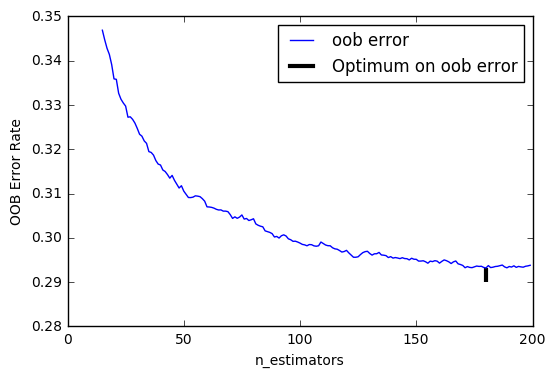

In [14]:
param_setting = {
    'n_estimators': 200
}

oob_score = plot_oob_error(x, 
                           y,
                           param_setting=param_setting,
                           seed=SEED)

The plot shows that ntree = 200 is large enough since the error doesn't seem to decrease much
after ntree is larger than 160.

In [22]:
best_iter = oob_score.index(min(oob_score))

In [23]:
ntree = best_iter+1

In [24]:
def parameter_tuning(model, X_train, y_train, param_grid, fold=5):   
    """
    Tune a tree based model using GridSearch, and return a model object with an updated parameters
    
    Parameters
    ----------
    model: sklearn's ensemble tree model
        the model we want to do the hyperparameter tuning.
    
    X_train: pandas DataFrame
        Preprocessed training data. Note that all the columns should be in numeric format.
    
    y_train: pandas Series
    
    param_grid: dict
        contains all the parameters that we want to tune for the responding model.    
        

    Note
    ----------
    * we use kfold in GridSearchCV in order to make sure the CV Score is consistent with the score 
      that we get from all the other function, including fit_bagging, fit_randomforest and fit_gbm. 
    * We use model_selection.KFold with fixed seed in order to make sure GridSearchCV uses the same seed as model_selection.cross_val_score.
    
    """
    seed=SEED
    
#     if 'n_estimators' in param_grid:
#         model.set_params(warm_start=True) 
    
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)
    gs_model = GridSearchCV(model, param_grid, cv=kfold, scoring='roc_auc')
    gs_model.fit(X_train, y_train)
    
    # best hyperparameter setting
    print('best parameters:{}'.format(gs_model.best_params_)) 
    print('best score:{}'.format(gs_model.best_score_)) 
    
    # refit model on best parameters
    model.set_params(**gs_model.best_params_)
    model.fit(X_train, y_train)

    return(model)

In [25]:
rf = RandomForestClassifier(n_estimators=ntree, random_state=SEED)

In [26]:
param_grid_rf_1 = {
    'min_samples_leaf': [1,3,5,10],                    
    'max_features': ['auto', 'log2', 3, 15, 20],
} 

In [27]:
rf_2 = parameter_tuning(rf, x, y, param_grid_rf_1)

best parameters:{'min_samples_leaf': 5, 'max_features': 20}
best score:0.7782775315968671


In [28]:
rf_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=166, n_jobs=1, oob_score=False,
            random_state=12345, verbose=0, warm_start=False)

## <a id="model">Feature Importance</a>

In [29]:
def get_variance_imp_df(model):
    """get the variance importance dataframe for tree based models"""
    
    var_imp = pd.DataFrame(x.columns, model.feature_importances_).reset_index().rename(columns={'index': 'importance',0:'feature'}).sort_values(by=['importance'], ascending=False)
    var_imp = var_imp[['feature','importance']].reset_index(drop=True)
    
    return(var_imp)

In [30]:
rf_imp = get_variance_imp_df(rf_2)
rf_imp.head(15)

,feature,importance
0,age,0.169559
1,avg_time,0.109469
2,unique_action,0.101388
3,obs_count,0.083635
4,gender_-unknown-,0.061976
5,total_actions,0.056277
6,ajax_refresh_subtotal,0.043615
7,personalize,0.041702
8,dashboard,0.033649
9,similar_listings,0.033268


In [33]:
rf_imp.to_csv('../data/rf_imp.csv', sep=',', index = False)

In [31]:
def viz_importance(var_imp, top):
    y_pos = np.arange(1, top + 1)
    plt.barh(y_pos, list(var_imp['importance'])[0:top][::-1], align = 'center')#, xerr = scores_std[0:top]
    plt.yticks(y_pos, var_imp['feature'][0:top][::-1])
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')   

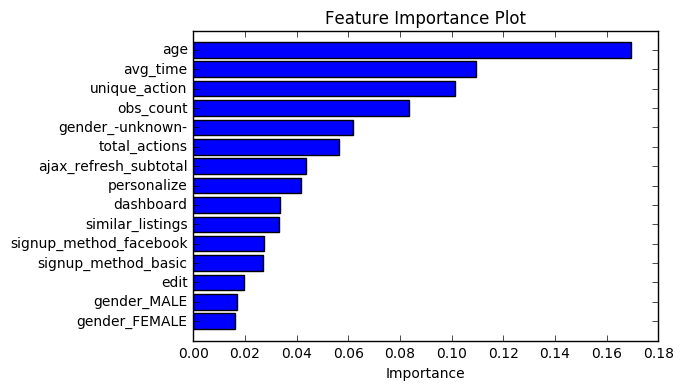

In [32]:
viz_importance(rf_imp, top=15)

#### Reference
* [OOB Errors for Random Forests](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py)
* [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)